### Import Packages

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import load_model
from scipy import stats

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


### Data Preprocessing & Preparation

In [3]:
time_step = 6
wind_cols = ['uSq','e_uSq','n_uSq','Z2','Z3','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')
df2 = pd.read_csv('Data_1973_2004.csv')

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df2['TimeStamp_1'] = pd.to_datetime(df2['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)
df2.set_index('TimeStamp_1', inplace=True)

# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]

# Data normalization
scaled_wave = MinMaxScaler()
scaled_wave = scaled_wave.fit(df_train[['H']])

# Data preparation
def create_sequences(data, time_step):
    X = []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step+1), :])  # Past hours wind features
    return np.array(X)

X = create_sequences(df2[scaled_wind_cols].values, time_step)
print(X.shape)

(271746, 7, 6)


### Model Deployment

In [4]:
# Deploy model_reg0
model_reg0 = load_model('best_model_reg0.keras')
df2['H_pred0'] = 0.0
df2.loc[df2.index[time_step:], 'H_pred0'] = model_reg0.predict(X, verbose=0)

# Deploy model_cls
model_cls = load_model('best_model_cls.keras')
df2['Spike_prob'] = 0.0
df2.loc[df2.index[time_step:], 'Spike_prob'] = model_cls.predict(X, verbose=0)

# Deploy model_reg1
model_reg1 = load_model('model_reg1.keras')
df2['H_pred1'] = 0.0
df2.loc[df2.index[time_step:], 'H_pred1'] = model_reg1.predict(X, verbose=0)

# Deploy model_stack
H_pred = (1 - df2['Spike_prob']) * df2['H_pred0'] + df2['Spike_prob'] * df2['H_pred1']
df2['H_pred'] = scaled_wave.inverse_transform(H_pred.values.reshape(-1, 1))

# Save to CSV
df2.to_csv('Data_1973_2004.csv')
df2.head(10)

I0000 00:00:1748754907.654000 2549634 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38483 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
I0000 00:00:1748754909.018862 2549781 cuda_dnn.cc:529] Loaded cuDNN version 90300


,uSq,e_uSq,n_uSq,Z2,Z3,Z4,scaled_uSq,scaled_e_uSq,scaled_n_uSq,scaled_Z2,scaled_Z3,scaled_Z4,H_pred0,Spike_prob,H_pred1,H_pred
TimeStamp_1,,,,,,,,,,,,,,,,
1973-11-01 00:00:00,84.476135,57.612586,61.781934,1165.979518,16093.4,222128.707649,0.203203,0.783349,0.588009,0.256944,0.042553,0.007747,0.000000,0.000000,0.000000,0.000000
1973-11-01 01:00:00,72.305431,57.745684,43.514494,1078.721566,16093.4,240096.732733,0.173217,0.783573,0.543650,0.234647,0.042553,0.008772,0.000000,0.000000,0.000000,0.000000
1973-11-01 02:00:00,84.476135,67.465641,50.839007,1165.979518,16093.4,222128.707649,0.203203,0.799950,0.561436,0.256944,0.042553,0.007747,0.000000,0.000000,0.000000,0.000000
1973-11-01 03:00:00,77.720269,69.249267,35.284264,1118.384272,16093.4,231581.872272,0.186558,0.802955,0.523664,0.244782,0.042553,0.008286,0.000000,0.000000,0.000000,0.000000
1973-11-01 04:00:00,84.476135,75.268788,38.351363,1165.979518,16093.4,222128.707649,0.203203,0.813097,0.531112,0.256944,0.042553,0.007747,0.000000,0.000000,0.000000,0.000000
1973-11-01 05:00:00,84.476135,67.465641,50.839007,1165.979518,16093.4,222128.707649,0.203203,0.799950,0.561436,0.256944,0.042553,0.007747,0.000000,0.000000,0.000000,0.000000
1973-11-01 06:00:00,72.305431,3.784174,72.206339,1078.721566,16093.4,240096.732733,0.173217,0.692656,0.613323,0.234647,0.042553,0.008772,0.313025,0.886008,0.438039,4.310182
1973-11-01 07:00:00,48.163739,-5.869683,47.804734,880.408038,16093.4,294178.962794,0.113738,0.676391,0.554068,0.183973,0.042553,0.011857,0.237922,0.818819,0.430285,4.021787
1973-11-01 08:00:00,90.321074,4.727040,90.197292,1205.642224,16093.4,214821.211816,0.217604,0.694245,0.657011,0.267079,0.042553,0.007330,0.221435,0.882532,0.436170,4.179568


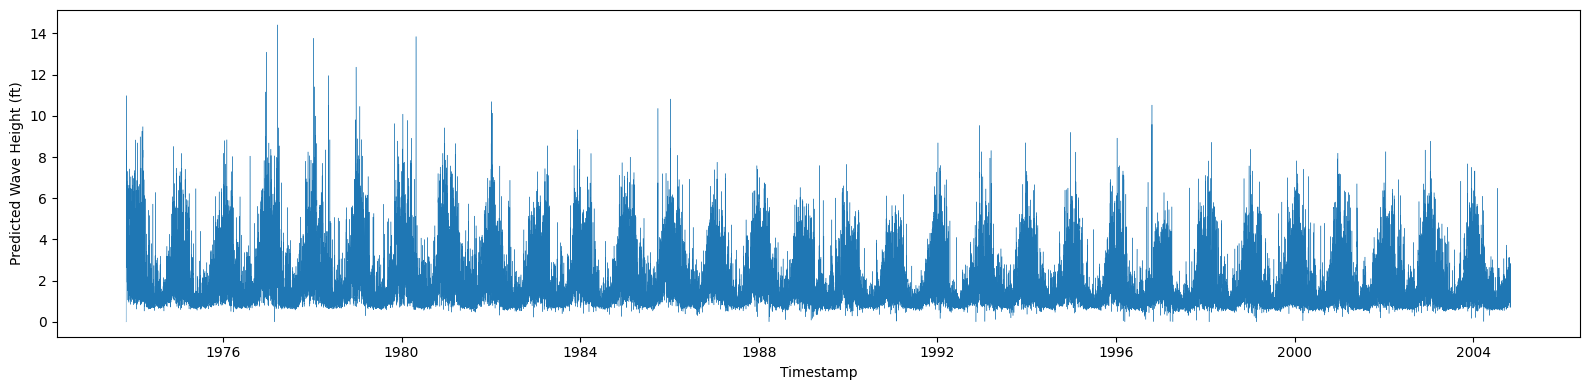

In [5]:
plt.figure(figsize=(16, 4))
plt.plot(df2.index, df2['H_pred'], linewidth=0.3)

plt.xlabel('Timestamp')
plt.ylabel('Predicted Wave Height (ft)')

plt.tight_layout()
plt.show()

xi: 0.2210
sigma: 0.5313


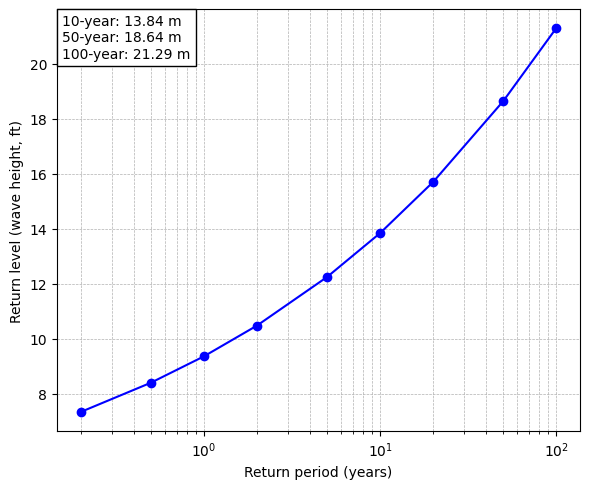

In [6]:
threshold = 5
SWH = df1['H']
exceedances = SWH[SWH > threshold] - threshold

xi, loc, sigma = stats.genpareto.fit(exceedances)
print('xi: {:.4f}'.format(xi))
print('sigma: {:.4f}'.format(sigma))

exceedance_rate = len(exceedances) / len(SWH)
return_periods = np.array([0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]) * 365 * 24
return_levels = threshold + (sigma / xi) * ((return_periods * exceedance_rate) ** xi - 1)

n_bootstrap = 1000
bootstrap_levels = np.zeros((n_bootstrap, len(return_periods)))

for i in range(n_bootstrap):
    resampled = np.random.choice(exceedances, size=len(exceedances), replace=True)
    xi_b, loc_b, sigma_b = stats.genpareto.fit(resampled)
    rl_b = threshold + (sigma_b / xi_b) * ((return_periods * exceedance_rate) ** xi_b - 1)
    bootstrap_levels[i, :] = rl_b

plt.figure(figsize=(6, 5))
plt.plot(return_periods / (365 * 24), return_levels, marker='o', color='b')
plt.xscale('log')
plt.xlabel('Return period (years)')
plt.ylabel('Return level (wave height, ft)')
plt.grid(True, which="both", ls="--", lw=0.5)

years_interest = [10, 50, 100]
hours_interest = np.array(years_interest) * 365 * 24
idx_interest = [np.where(return_periods == h)[0][0] for h in hours_interest]
rl_interest = return_levels[idx_interest]

legend_text = "\n".join([f"{yr}-year: {rl:.2f} m" for yr, rl in zip(years_interest, rl_interest)])
plt.gca().text(0.01, 0.885, legend_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black'), transform=plt.gca().transAxes)

plt.savefig("return_1.png", dpi=1200, format='png')
plt.tight_layout()
plt.show()

xi: 0.0227
sigma: 0.9767


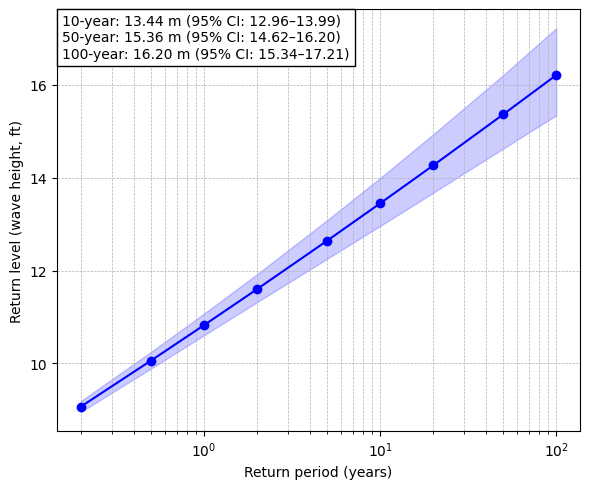

In [7]:
threshold = 5
SWH = pd.concat([df2['H_pred'], df1['H']], axis=0)
exceedances = SWH[SWH > threshold] - threshold

xi, loc, sigma = stats.genpareto.fit(exceedances)
print('xi: {:.4f}'.format(xi))
print('sigma: {:.4f}'.format(sigma))

exceedance_rate = len(exceedances) / len(SWH)
return_periods = np.array([0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]) * 365 * 24
return_levels = threshold + (sigma / xi) * ((return_periods * exceedance_rate) ** xi - 1)

n_bootstrap = 1000
bootstrap_levels = np.zeros((n_bootstrap, len(return_periods)))

for i in range(n_bootstrap):
    resampled = np.random.choice(exceedances, size=len(exceedances), replace=True)
    xi_b, loc_b, sigma_b = stats.genpareto.fit(resampled)
    rl_b = threshold + (sigma_b / xi_b) * ((return_periods * exceedance_rate) ** xi_b - 1)
    bootstrap_levels[i, :] = rl_b

lower_bound = np.percentile(bootstrap_levels, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_levels, 97.5, axis=0)

plt.figure(figsize=(6, 5))
plt.plot(return_periods / (365 * 24), return_levels, marker='o', color='b')
plt.fill_between(return_periods / (365 * 24), lower_bound, upper_bound, color='b', alpha=0.2)
plt.xscale('log')
plt.xlabel('Return period (years)')
plt.ylabel('Return level (wave height, ft)')
plt.grid(True, which="both", ls="--", lw=0.5)

years_interest = [10, 50, 100]
hours_interest = np.array(years_interest) * 365 * 24
idx_interest = [np.where(return_periods == h)[0][0] for h in hours_interest]

rl_interest = return_levels[idx_interest]
lb_interest = lower_bound[idx_interest]
ub_interest = upper_bound[idx_interest]

legend_text = "\n".join([
    f"{yr}-year: {rl:.2f} m (95% CI: {lb:.2f}–{ub:.2f})"
    for yr, rl, lb, ub in zip(years_interest, rl_interest, lb_interest, ub_interest)
])

plt.gca().text(0.01, 0.885, legend_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black'), transform=plt.gca().transAxes)

plt.savefig("return_2.png", dpi=1200, format='png')
plt.tight_layout()
plt.show()